# Reviewing rainfall around landfall using regions(admin 1)

This notebook looks at return period for rainfall around the landfall for storms at both region-level and overall for a 1-in-3 year threshold.

## Landfall rainfall

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.datasources import codab, imerg
from src.constants import *
from src import db_utils
from matplotlib.ticker import MaxNLocator
import math
import matplotlib.cm as cm

## Load data

### Landfall dates

In [3]:
load_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "mdg"
    / "landfall_time_location_fixed_adm0_v7.csv"
)
landfall_df = pd.read_csv(load_path)

In [4]:
# keeping only USA_WIND as this is the most complete wind record
cols = [
    "SID",
    "SEASON",
    "NAME",
    "USA_WIND",
    "LAT",
    "LON",
    "year",
    "month",
    "day",
]

landfall_df = landfall_df[cols]

date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)

# correct single negative USA_WIND
landfall_df["USA_WIND"] = landfall_df["USA_WIND"].abs()

In [5]:
landfall_df

SID  SEASON         NAME    USA_WIND        LAT        LON  \
0   1999357S08076  2000.0      ASTRIDE   40.000000 -12.800000  49.000000   
1   2000032S11116  2000.0  ELINE:LEONE   77.000000 -19.666667  48.833333   
2   2000058S14063  2000.0       GLORIA   50.000000 -13.900000  50.100000   
3   2000083S17102  2000.0        HUDAH  113.833333 -15.066667  50.300000   
4   2001064S10052  2001.0         DERA   25.000000 -12.600000  49.600000   
..            ...     ...          ...         ...        ...        ...   
69  2022110S12051  2022.0      JASMINE   20.000000 -12.150000  49.300000   
70  2023018S14058  2023.0      CHENESO   47.666667 -14.000000  50.066667   
71  2023036S12118  2023.0       FREDDY   89.833333 -21.066667  48.400000   
72  2024001S21041  2024.0       ALVARO   55.500000 -21.450000  43.500000   
73  2024086S13051  2024.0       GAMANE   85.666667 -12.900000  49.850000   

    year  month  day landfall_date  
0   2000      1    1    2000-01-01  
1   2000      2   17    2000-02-17  
2   2000      3    1    2000-03-01  
3   2000      4    2    2000-04-02  
4   2001      3    5    2001-03-05  
..   ...    ...  ...           ...  
69  2022      4   20    2022-04-20  
70  2023      1   19    2023-01-19  
71  2023      2   21    2023-02-21  
72  2024      1    1    2024-01-01  
73  2024      3   27    2024-03-27  

[74 rows x 10 columns]

### CODAB

In [6]:
adm1 = codab.load_codab(admin_level=1)

<Axes: >

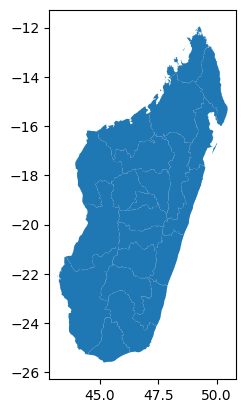

In [7]:
adm1.plot()

In [8]:
aoi_adm1_pcodes = adm1["ADM1_PCODE"].unique()

### IMERG

In [9]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
dfs = []
for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["SID"] = sid
    dfs.append(df_in)

ASTRIDE too early
ELINE:LEONE too early
GLORIA too early
HUDAH too early


In [10]:
imerg_df = pd.concat(dfs, ignore_index=True)

In [11]:
imerg_df

iso3 pcode  valid_date  adm_level        mean      median        min  \
0     MDG  MG11  2001-03-04          1    8.576155    2.360000   0.000000   
1     MDG  MG11  2001-03-05          1    0.198000    0.000000   0.000000   
2     MDG  MG11  2001-03-06          1    0.576778    0.005000   0.000000   
3     MDG  MG12  2001-03-04          1   19.299845    7.790000   0.000000   
4     MDG  MG12  2001-03-05          1    5.407058    0.640000   0.000000   
...   ...   ...         ...        ...         ...         ...        ...   
4615  MDG  MG71  2024-03-27          1  141.691180  130.235000   6.350000   
4616  MDG  MG71  2024-03-28          1   73.439640   68.950010  12.000000   
4617  MDG  MG72  2024-03-26          1   94.133810   87.844990  15.429998   
4618  MDG  MG72  2024-03-27          1  147.300780  151.584990  21.265001   
4619  MDG  MG72  2024-03-28          1   56.970990   55.634995  13.184999   

             max  count            sum        std            SID  
0     266.795040    585    5017.050300  26.564947  2001064S10052  
1       5.160000    585     115.829994   0.516773  2001064S10052  
2      10.455000    585     337.414980   1.263053  2001064S10052  
3      98.060000    617   11908.005000  22.802630  2001064S10052  
4     273.279970    617    3336.155000  22.575636  2001064S10052  
...          ...    ...            ...        ...            ...  
4615  357.130040    657   93091.110000  63.347960  2024086S13051  
4616  253.869960    657   48249.840000  36.944950  2024086S13051  
4617  182.760000    792   74553.980000  35.862470  2024086S13051  
4618  299.230000    792  116662.220000  64.588875  2024086S13051  
4619   99.370026    792   45121.023000  19.092758  2024086S13051  

[4620 rows x 12 columns]

In [12]:
imerg_sum_df = imerg_df.groupby(["pcode", "SID"])["mean"].sum().reset_index()
imerg_sum_df = imerg_sum_df.rename(columns={"mean": "sum_mean_rain"})
imerg_sum_df

pcode            SID  sum_mean_rain
0     MG11  2001064S10052       9.350933
1     MG11  2001364S19036      28.826341
2     MG11  2002045S18049      43.899153
3     MG11  2002063S11066      20.117050
4     MG11  2002122S07063     150.175825
...    ...            ...            ...
1535  MG72  2022110S12051     136.802133
1536  MG72  2023018S14058     158.032874
1537  MG72  2023036S12118      10.738251
1538  MG72  2024001S21041      38.691477
1539  MG72  2024086S13051     298.405580

[1540 rows x 3 columns]

## Combine data

In [13]:
combined_df = landfall_df.merge(imerg_sum_df).merge(
    adm1.rename(columns={"ADM1_PCODE": "pcode"})[["pcode", "ADM1_EN"]]
)
combined_df["nameseason"] = (
    combined_df["NAME"].str.capitalize()
    + " "
    + combined_df["year"].astype(str)
)
combined_df

SID  SEASON    NAME   USA_WIND   LAT    LON  year  month  day  \
0     2001064S10052  2001.0    DERA  25.000000 -12.6  49.60  2001      3    5   
1     2001064S10052  2001.0    DERA  25.000000 -12.6  49.60  2001      3    5   
2     2001064S10052  2001.0    DERA  25.000000 -12.6  49.60  2001      3    5   
3     2001064S10052  2001.0    DERA  25.000000 -12.6  49.60  2001      3    5   
4     2001064S10052  2001.0    DERA  25.000000 -12.6  49.60  2001      3    5   
...             ...     ...     ...        ...   ...    ...   ...    ...  ...   
1535  2024086S13051  2024.0  GAMANE  85.666667 -12.9  49.85  2024      3   27   
1536  2024086S13051  2024.0  GAMANE  85.666667 -12.9  49.85  2024      3   27   
1537  2024086S13051  2024.0  GAMANE  85.666667 -12.9  49.85  2024      3   27   
1538  2024086S13051  2024.0  GAMANE  85.666667 -12.9  49.85  2024      3   27   
1539  2024086S13051  2024.0  GAMANE  85.666667 -12.9  49.85  2024      3   27   

     landfall_date pcode  sum_mean_rain          ADM1_EN   nameseason  
0       2001-03-05  MG11       9.350933       Analamanga    Dera 2001  
1       2001-03-05  MG12      26.039796   Vakinankaratra    Dera 2001  
2       2001-03-05  MG13      21.135378            Itasy    Dera 2001  
3       2001-03-05  MG14      23.999404        Bongolava    Dera 2001  
4       2001-03-05  MG21      18.947615  Haute Matsiatra    Dera 2001  
...            ...   ...            ...              ...          ...  
1535    2024-03-27  MG52       0.000680           Androy  Gamane 2024  
1536    2024-03-27  MG53       0.029971            Anosy  Gamane 2024  
1537    2024-03-27  MG54       0.105438           Menabe  Gamane 2024  
1538    2024-03-27  MG71     257.909747            Diana  Gamane 2024  
1539    2024-03-27  MG72     298.405580             Sava  Gamane 2024  

[1540 rows x 14 columns]

## Plot

In [14]:
def calculate_rp(group, col_name, total_seasons):
    group["rank"] = group[col_name].rank(ascending=False)
    group["rp"] = (total_seasons + 1) / group["rank"]
    return group

In [15]:
# seasons for RP calc is total seasons minus current season
total_seasons = combined_df["SEASON"].nunique() - 1

C:\Users\pauni\AppData\Local\Temp\ipykernel_45236\2106774656.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(dpi=200)


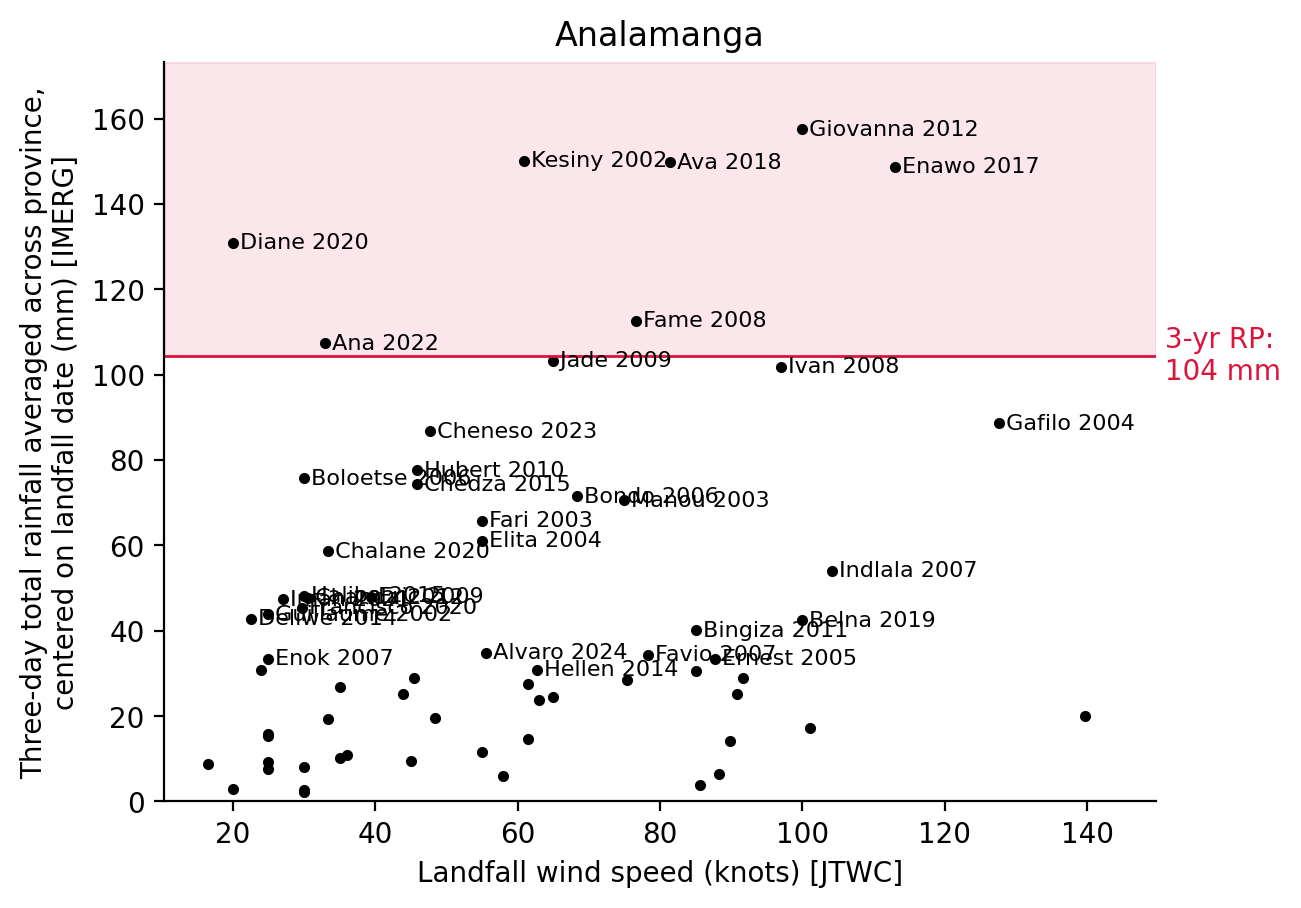

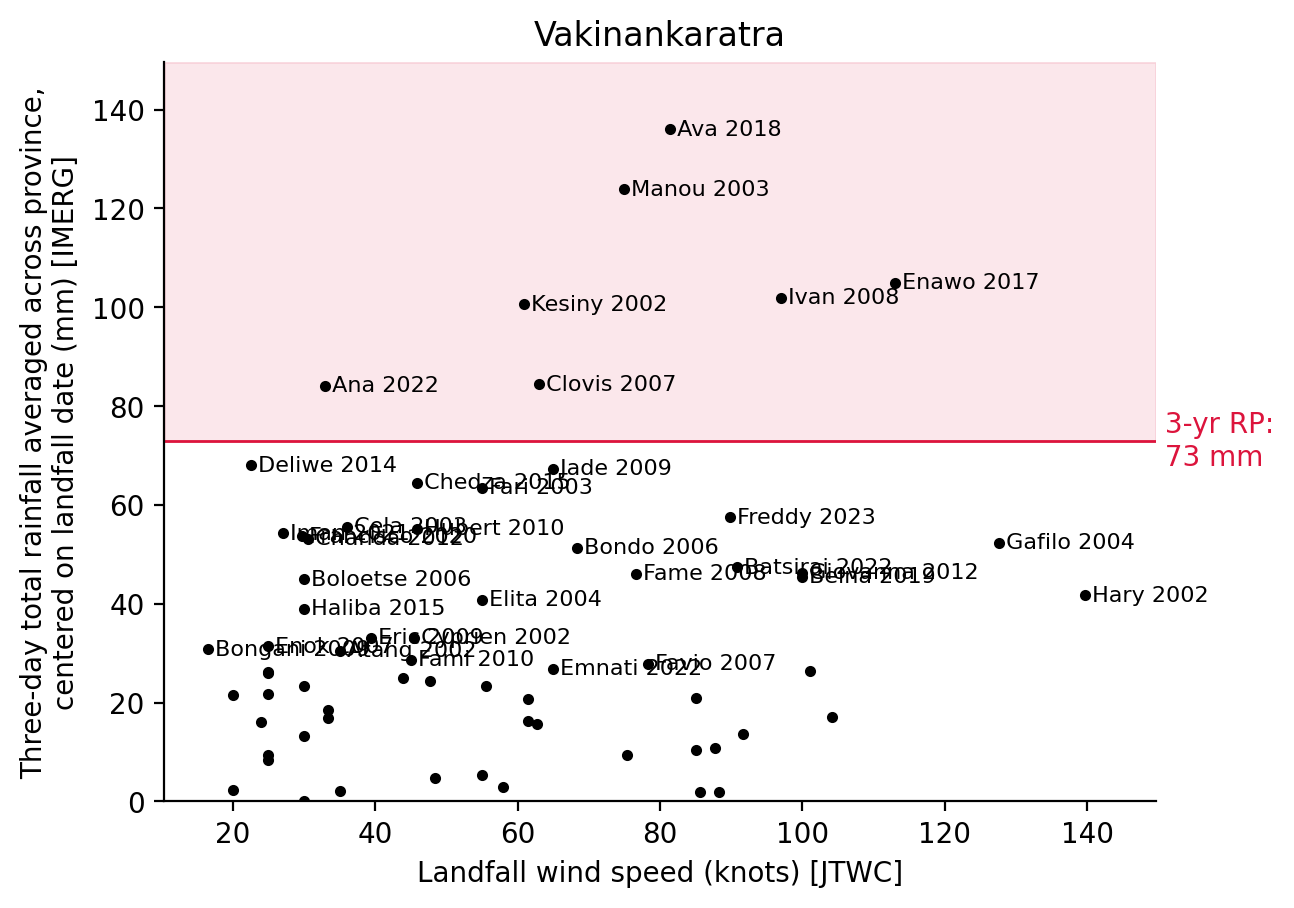

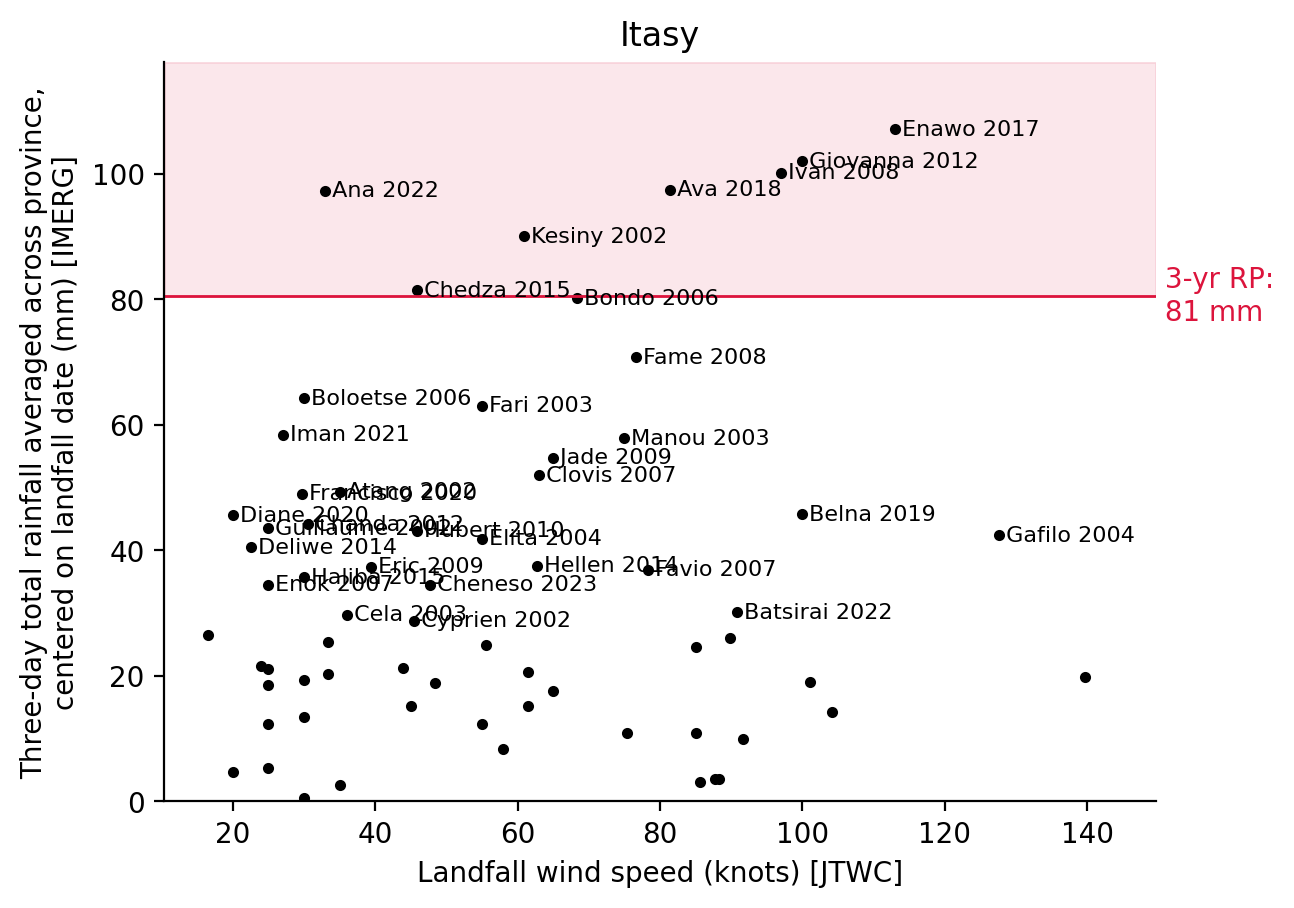

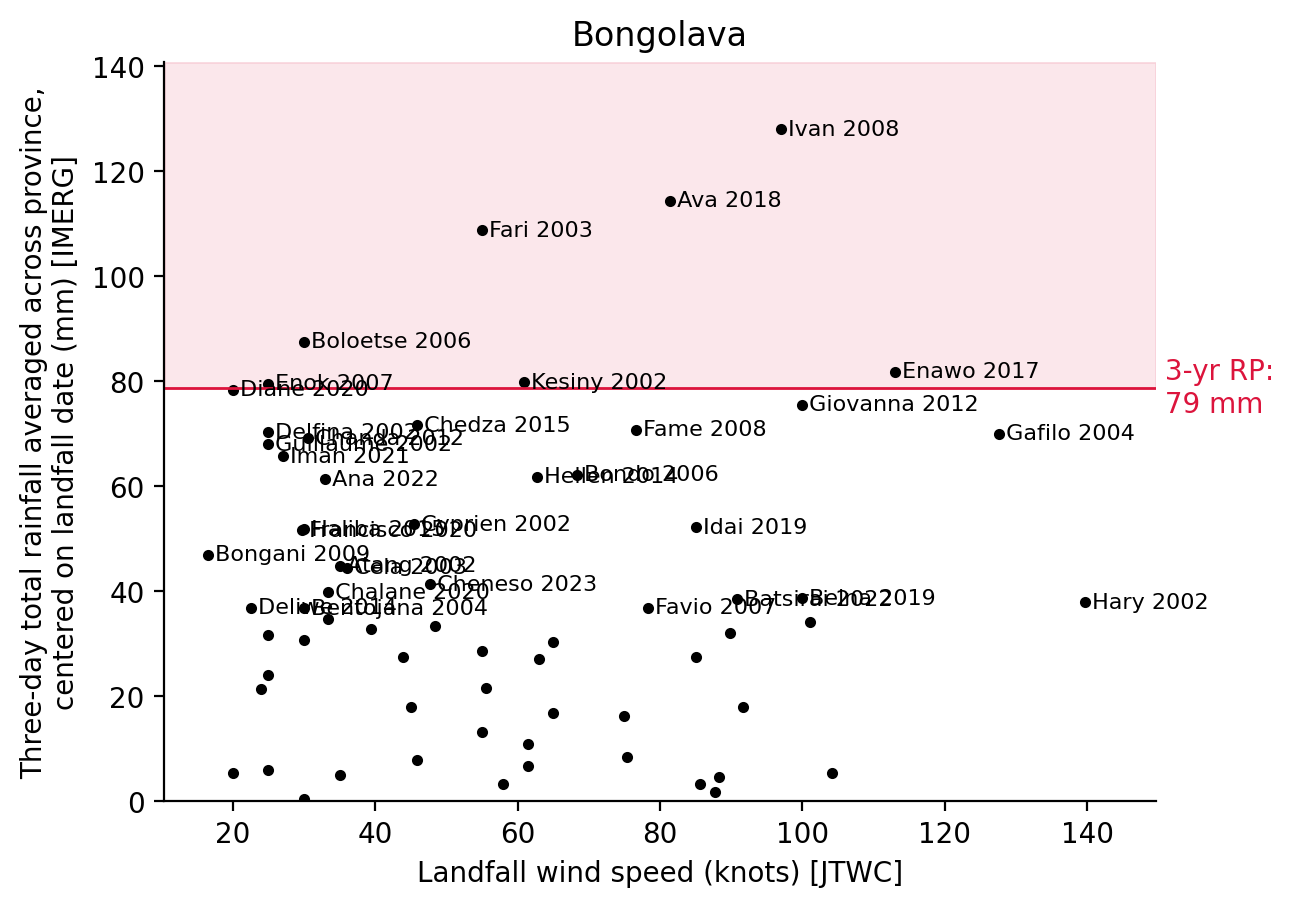

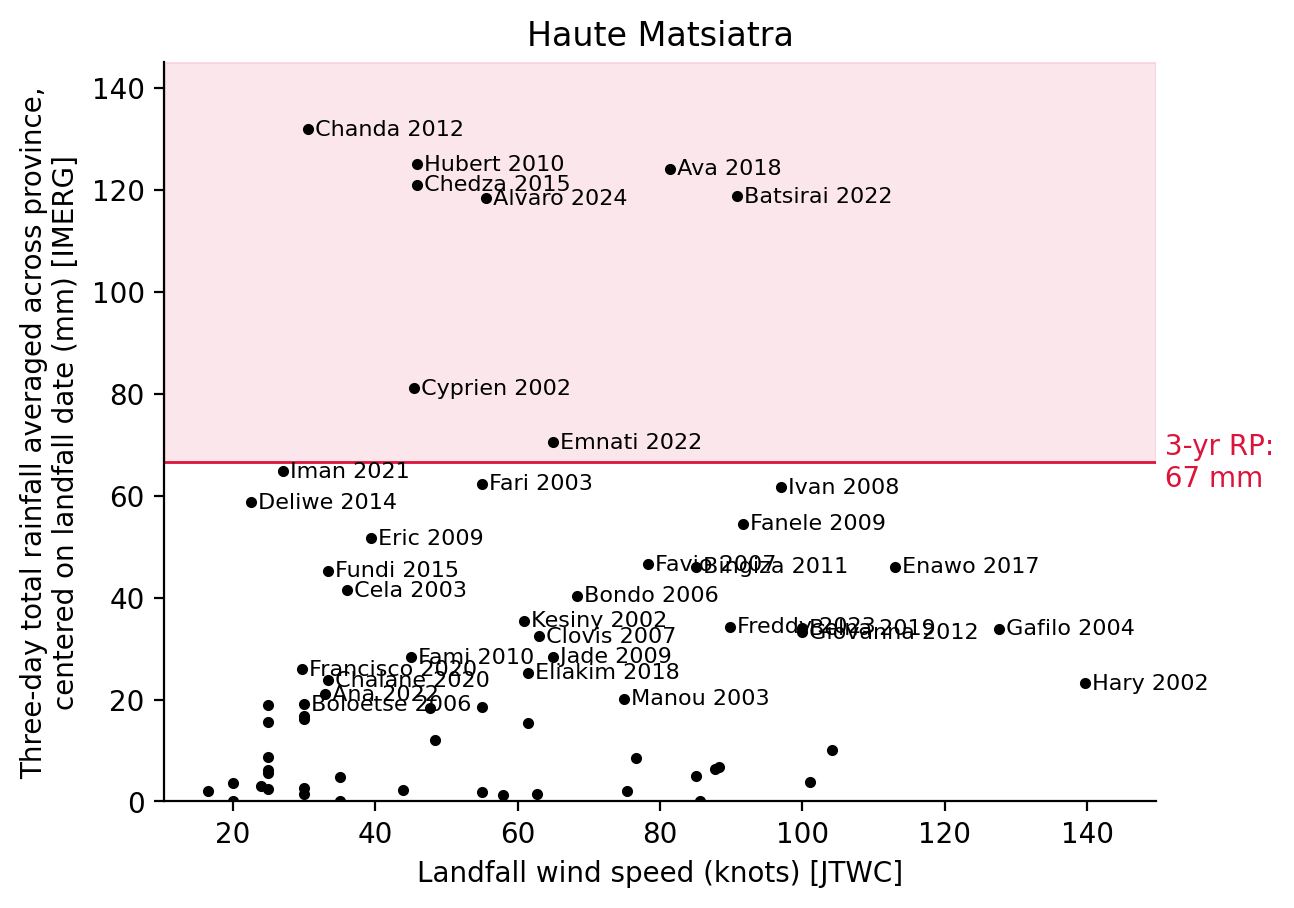

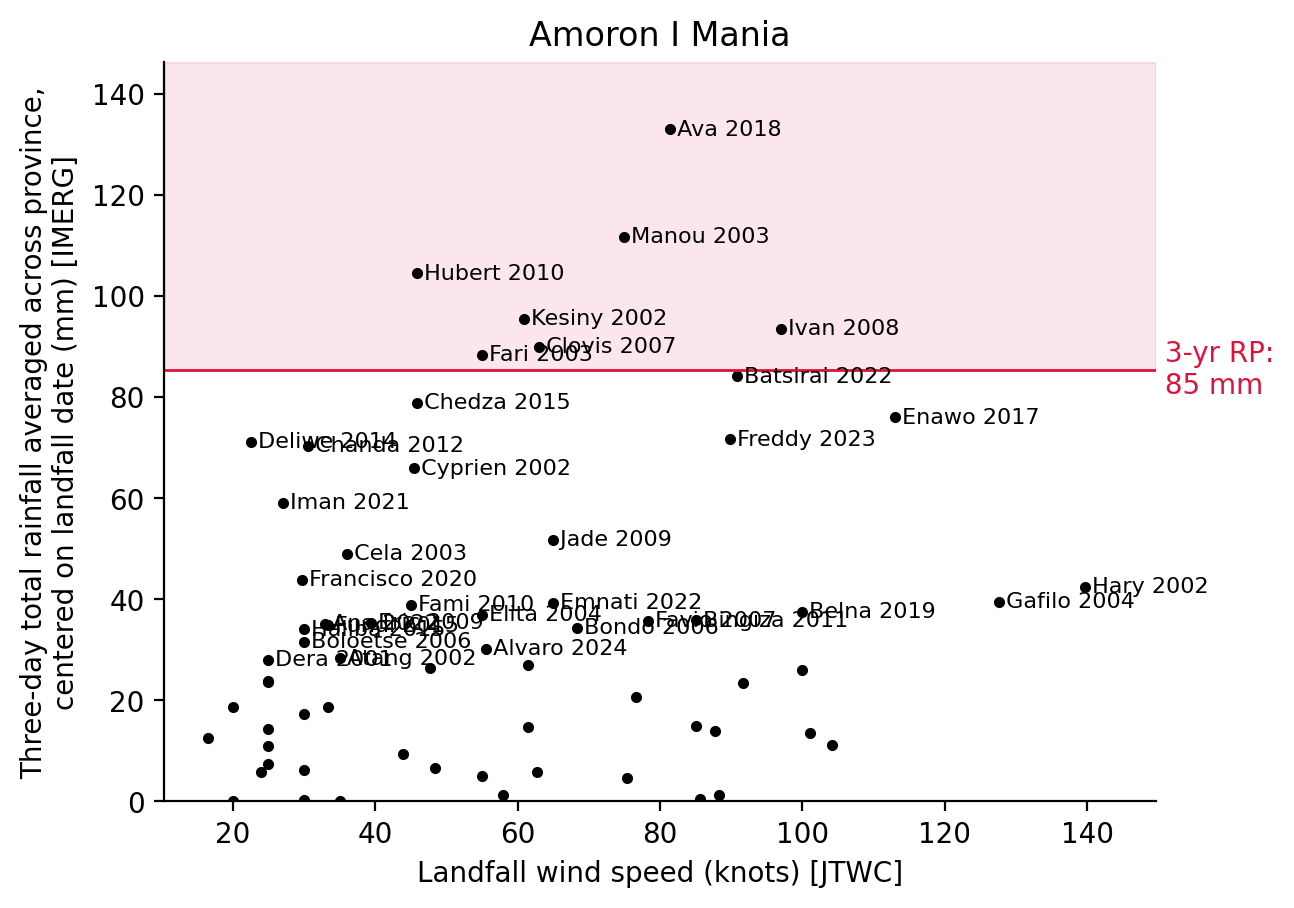

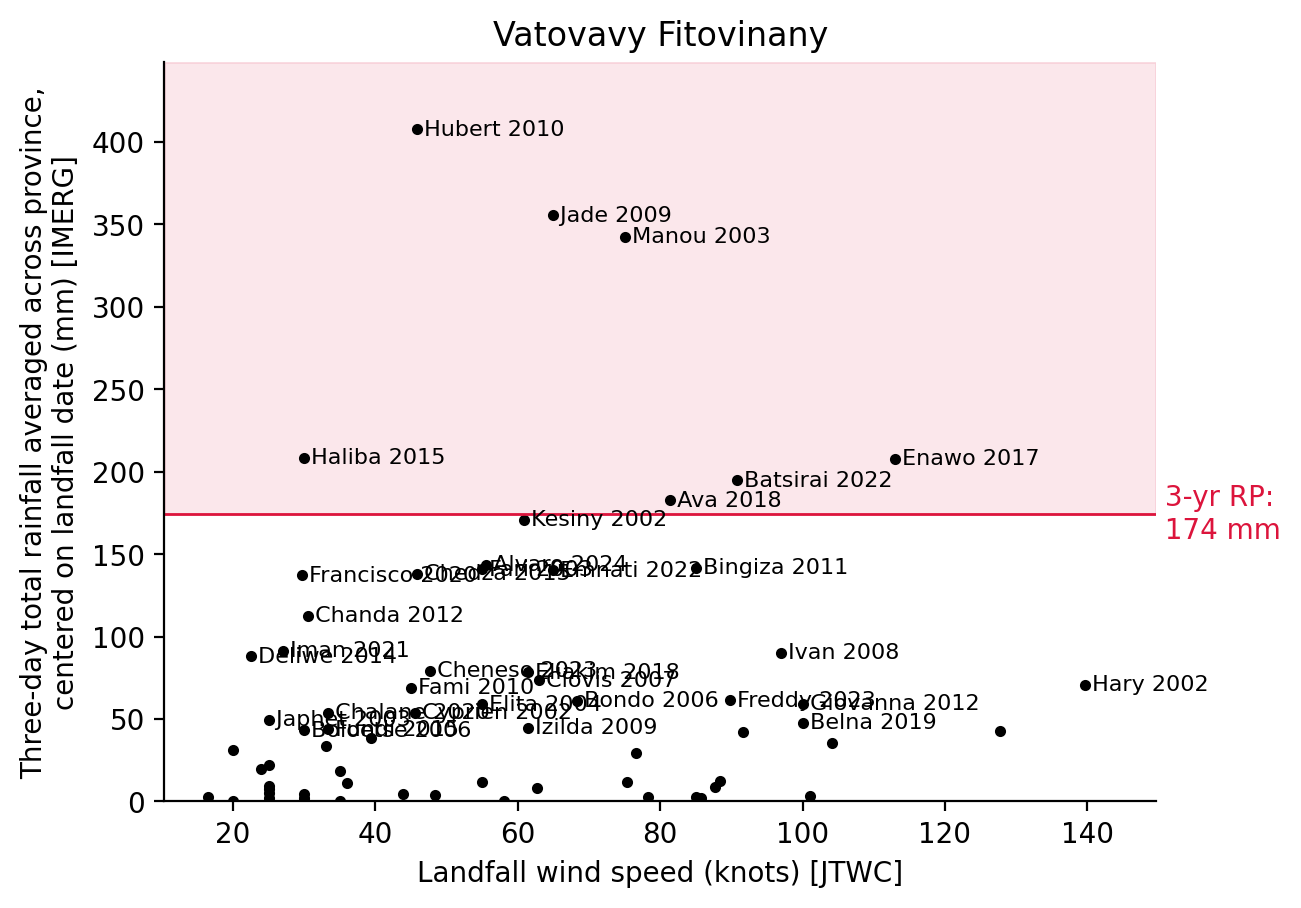

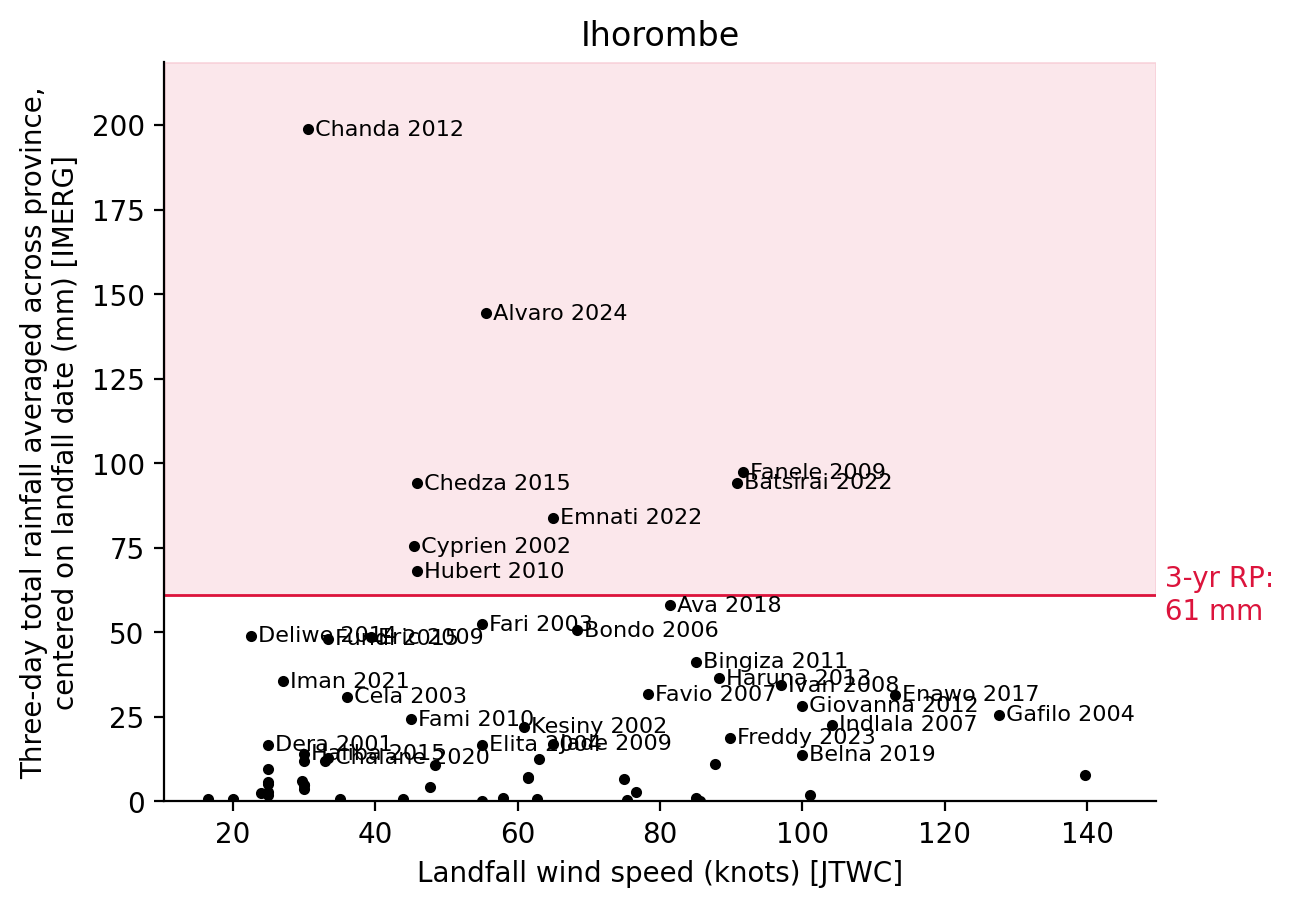

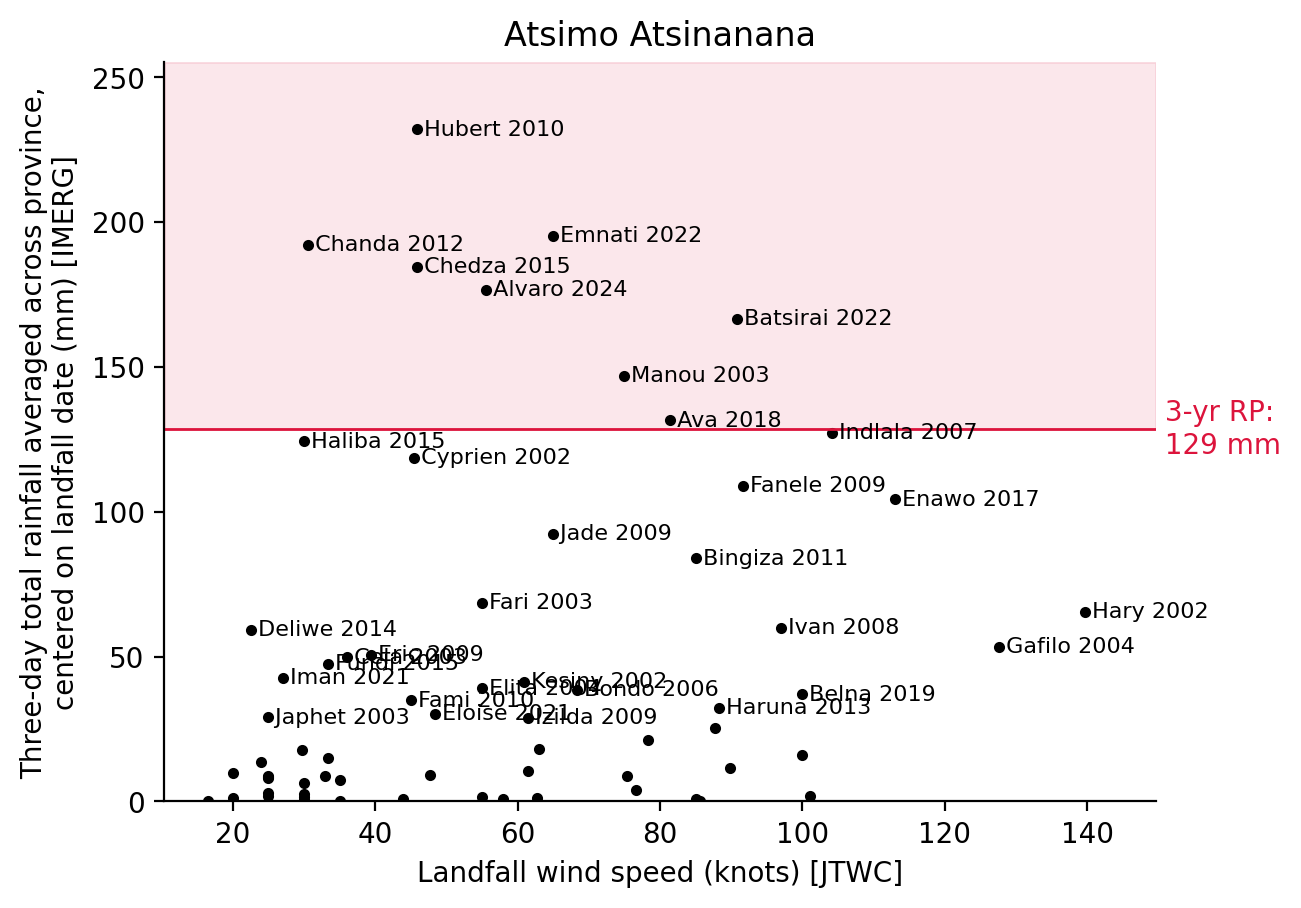

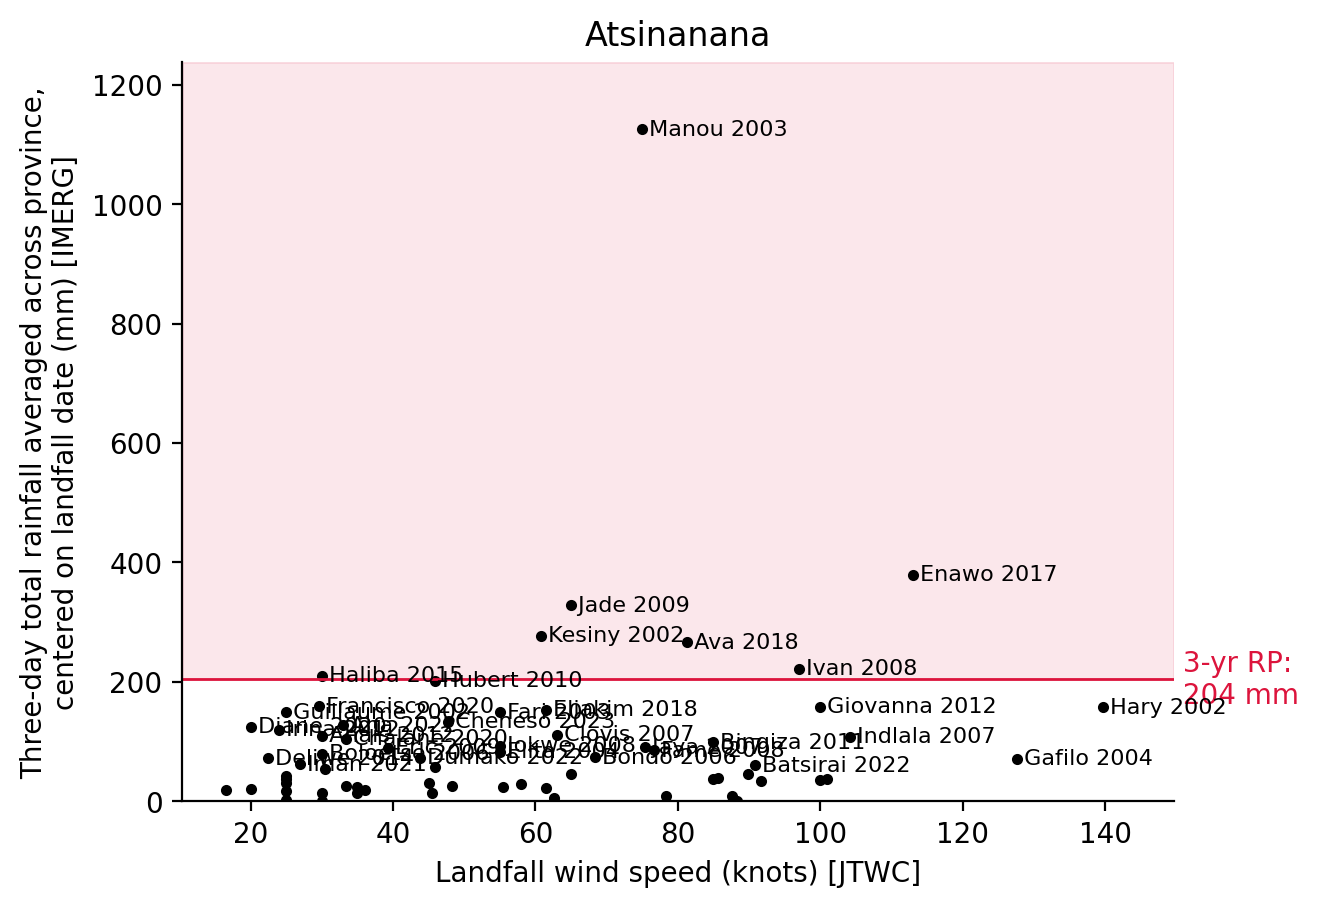

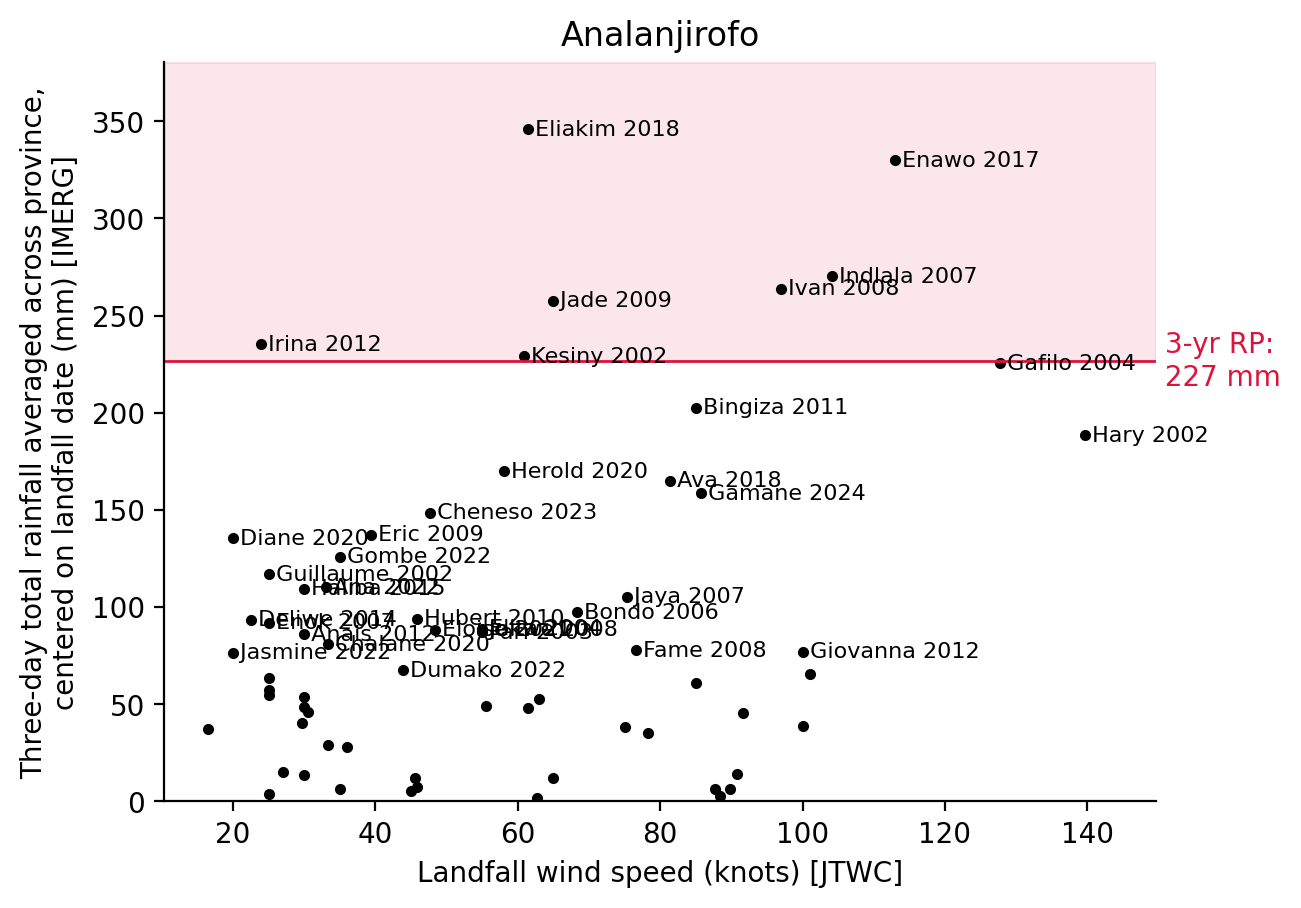

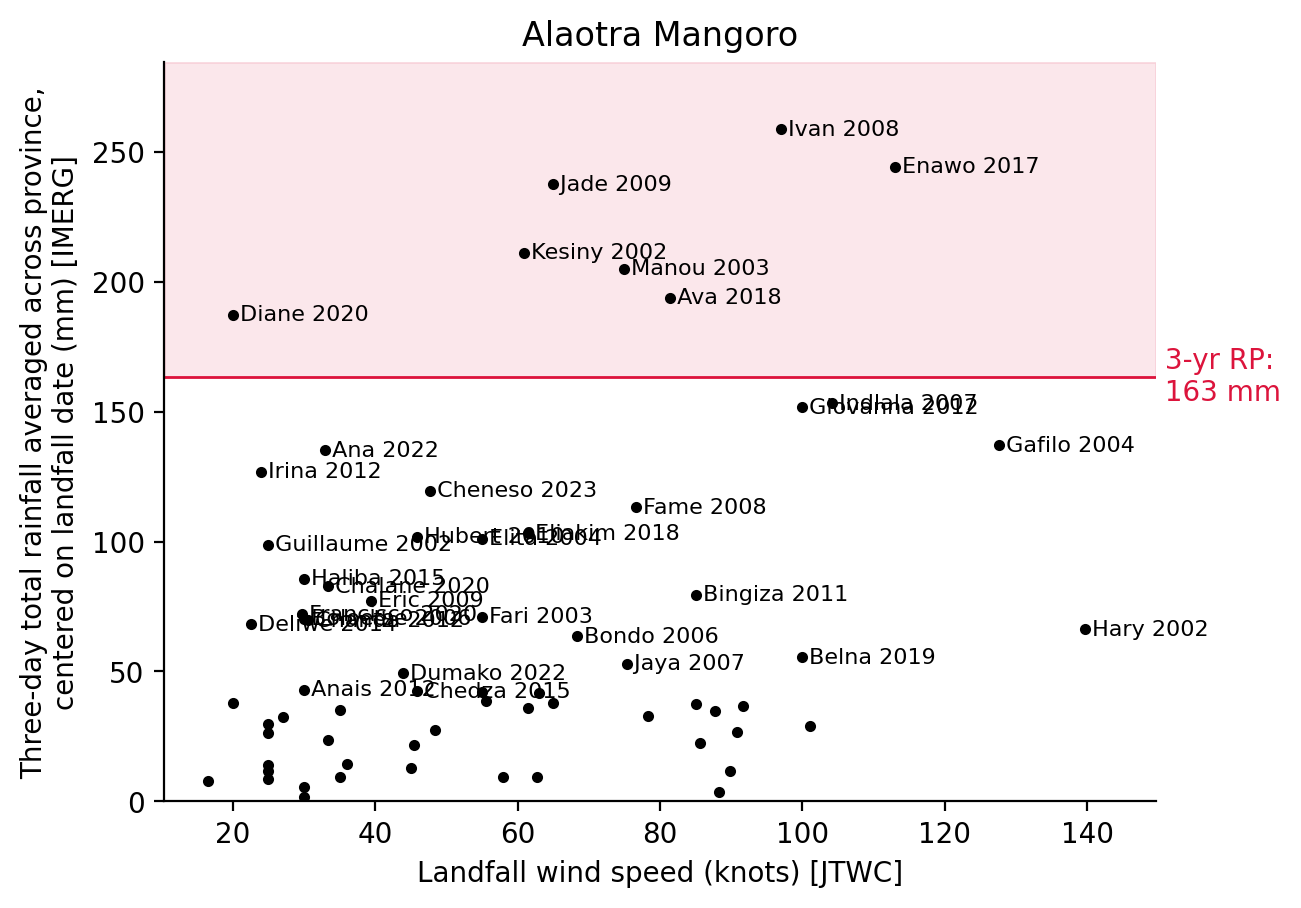

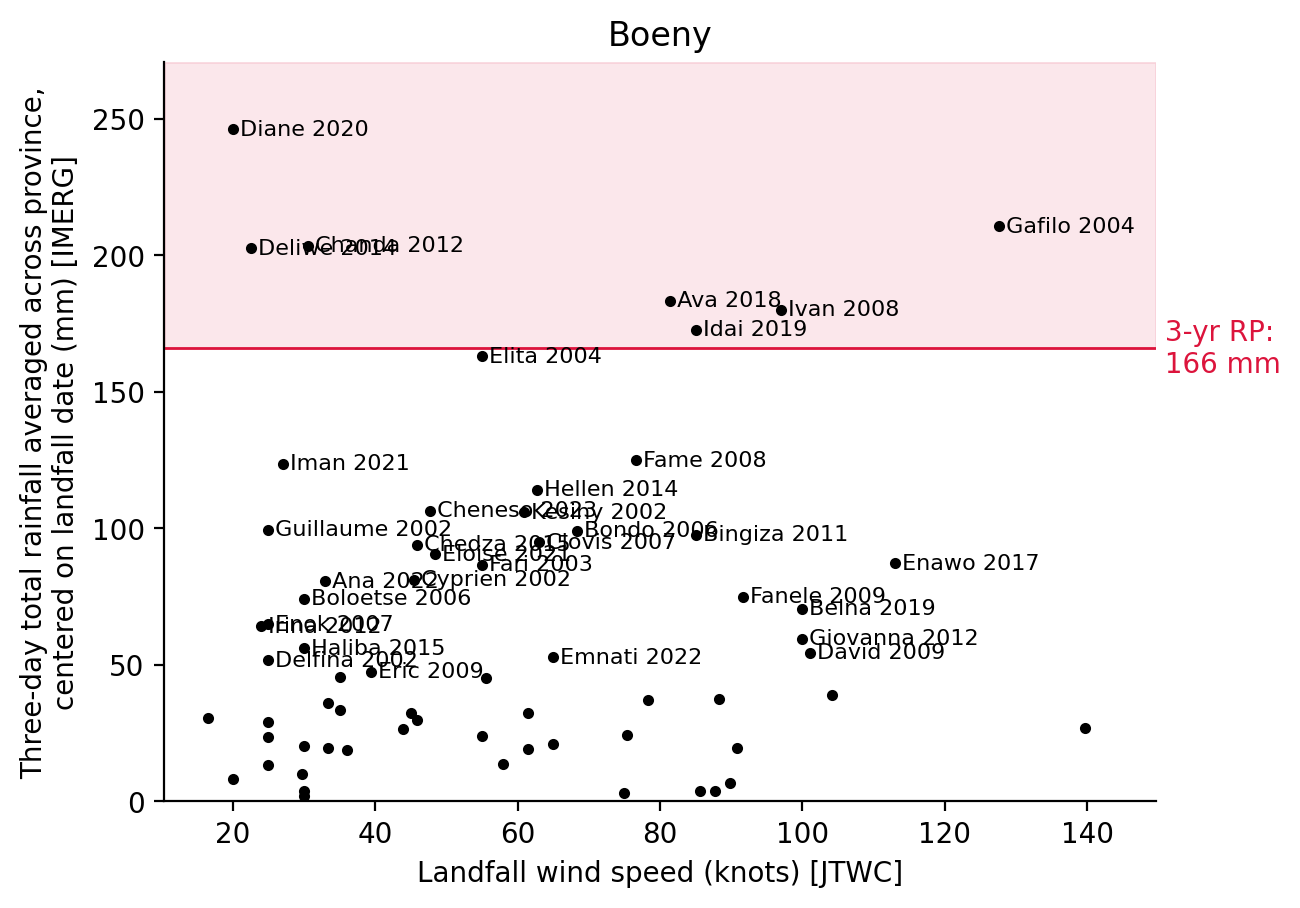

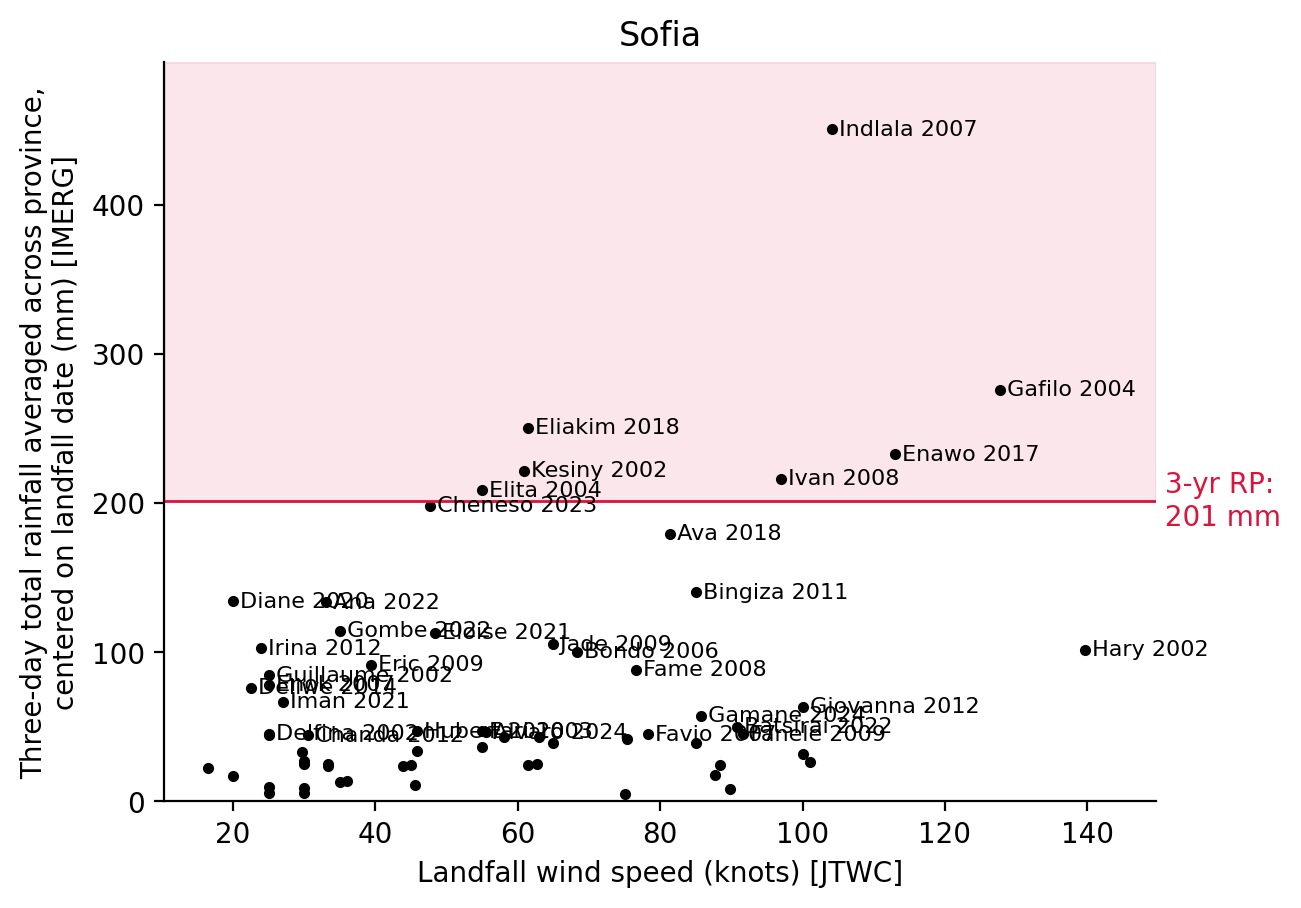

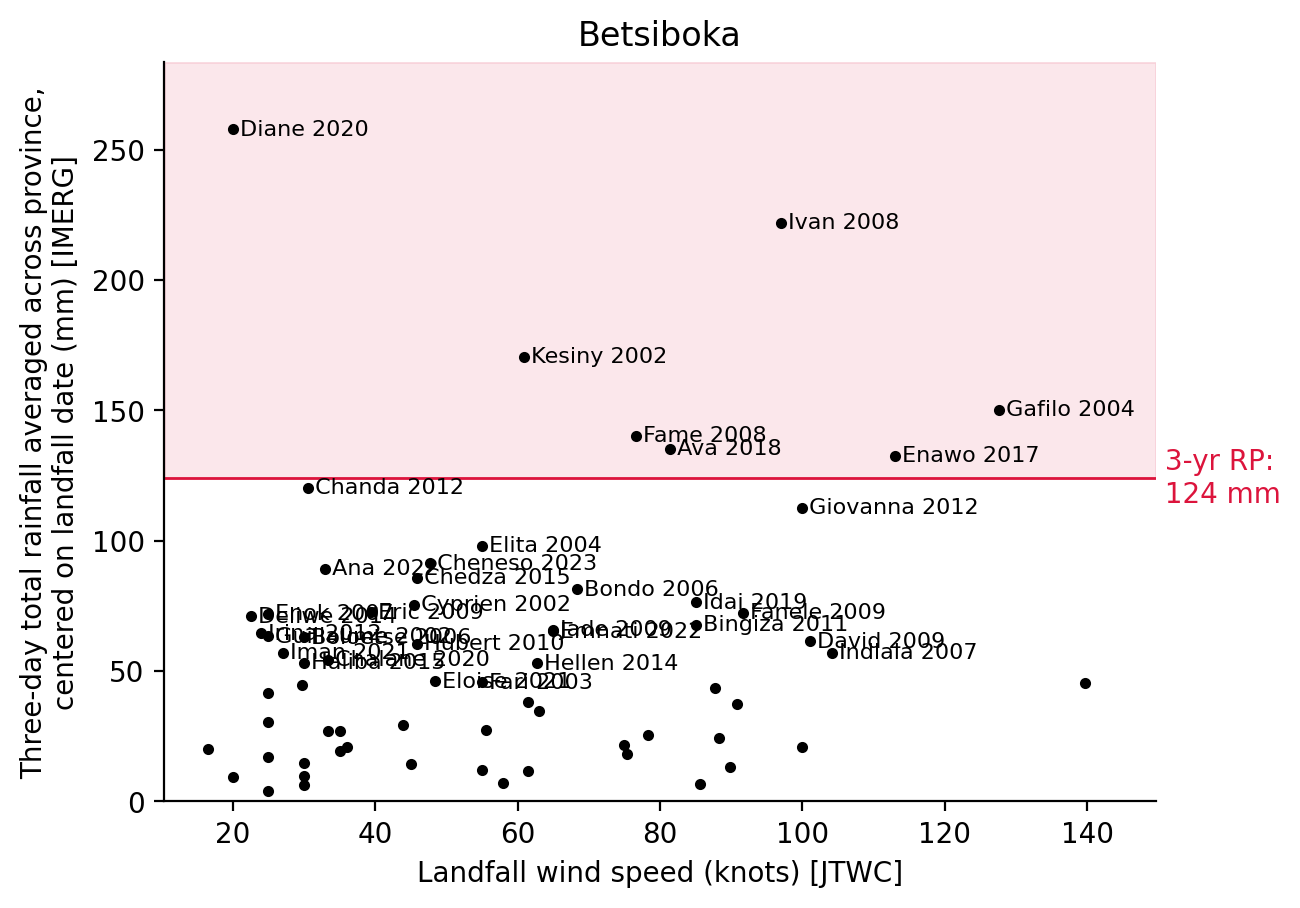

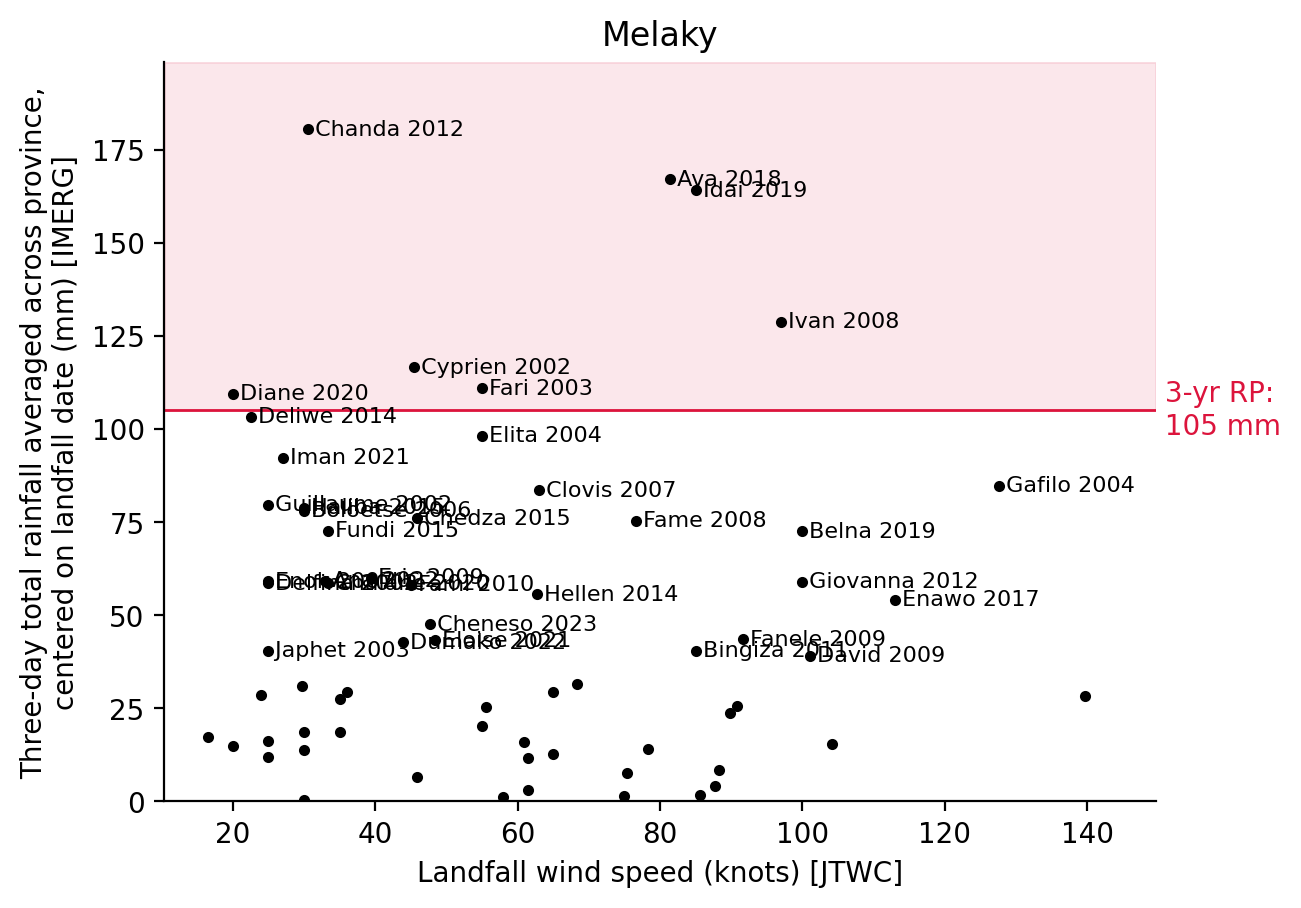

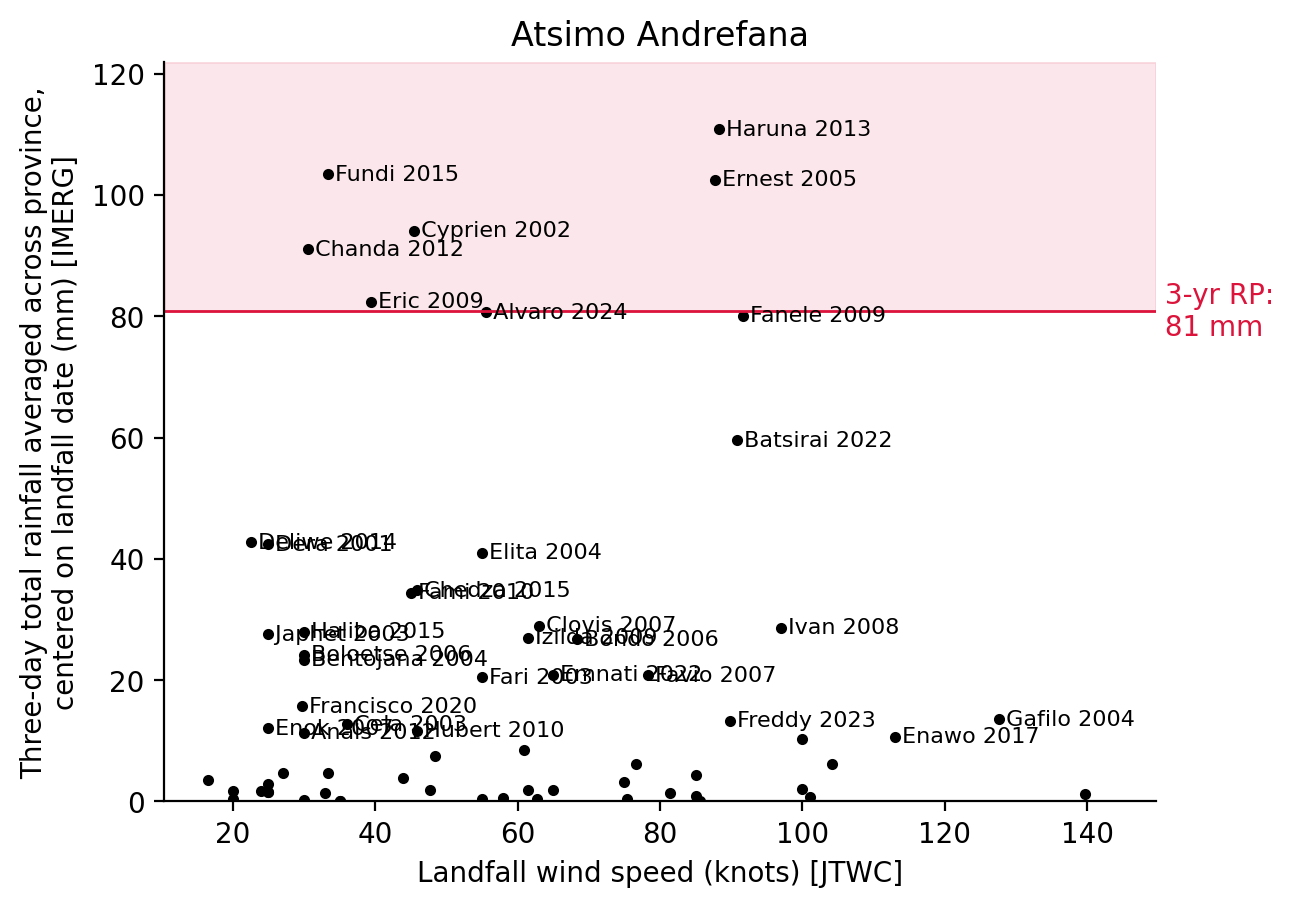

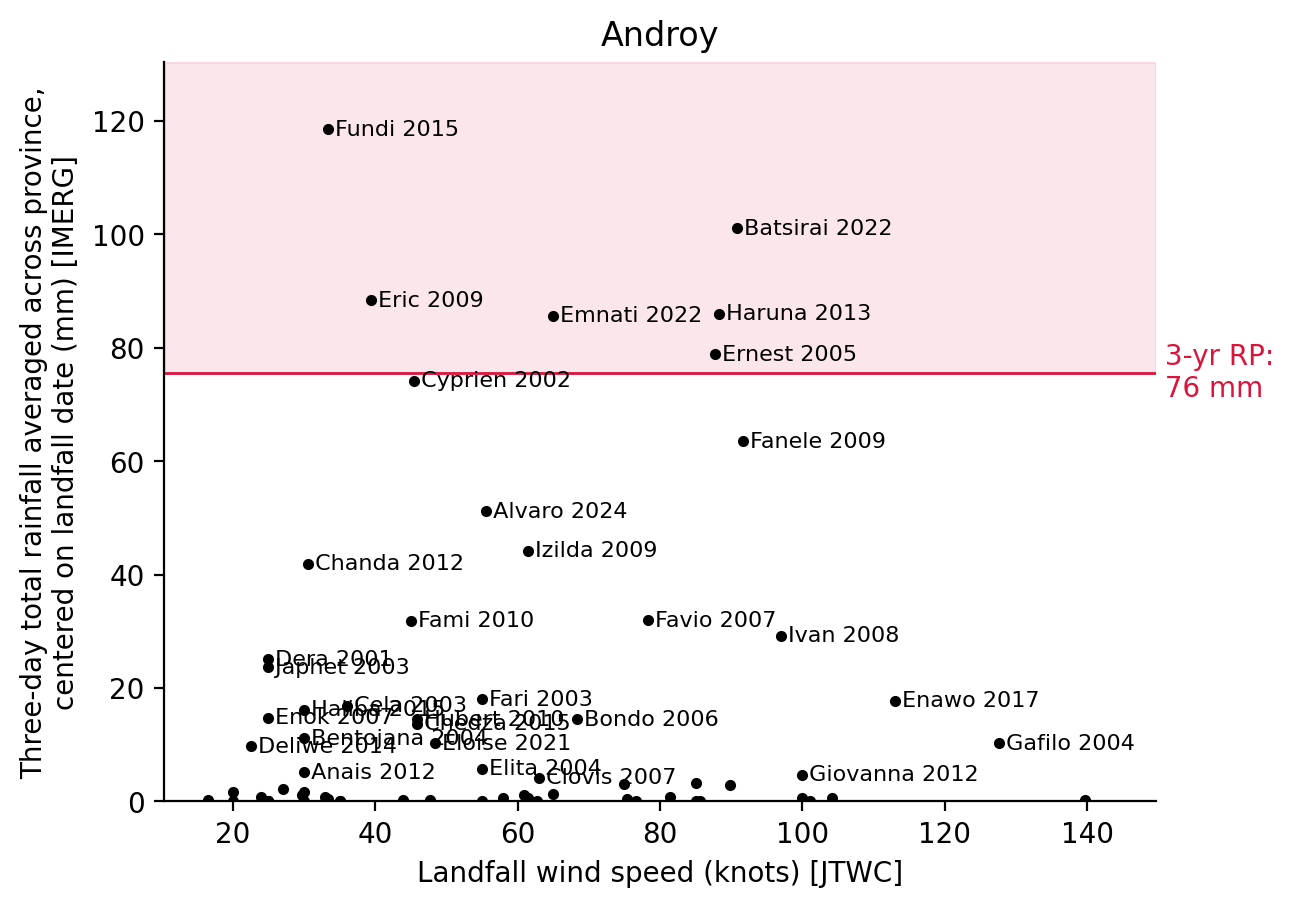

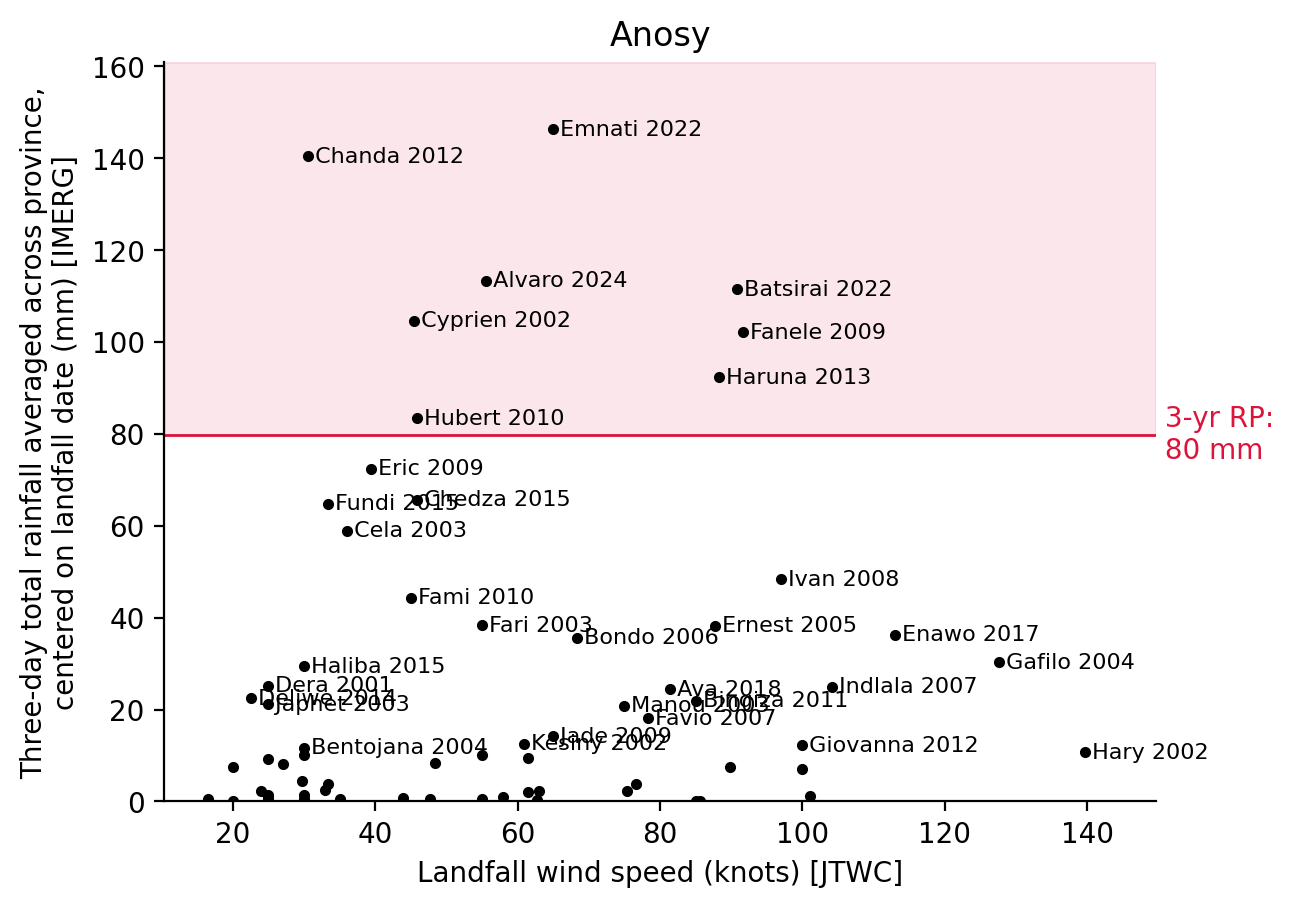

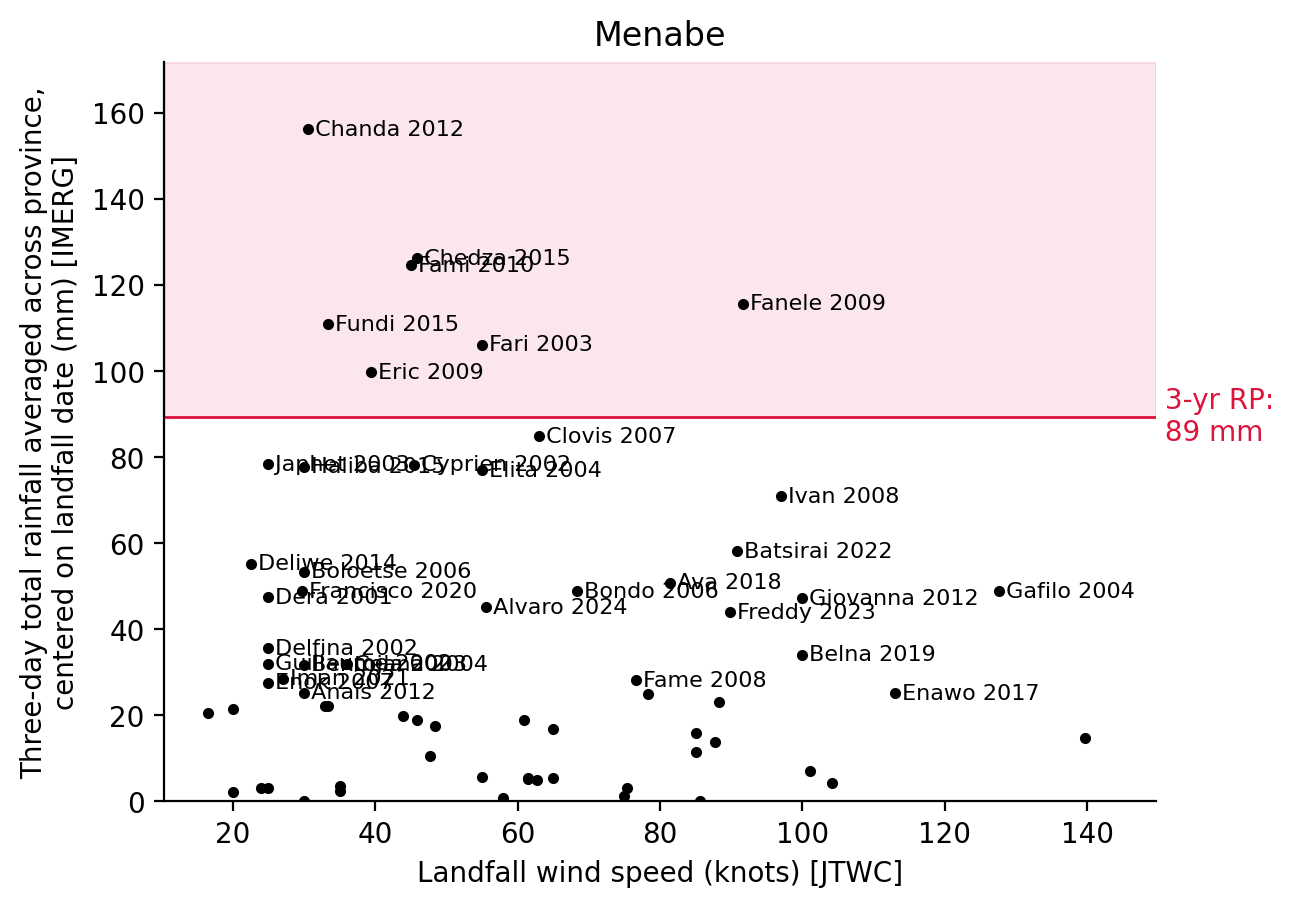

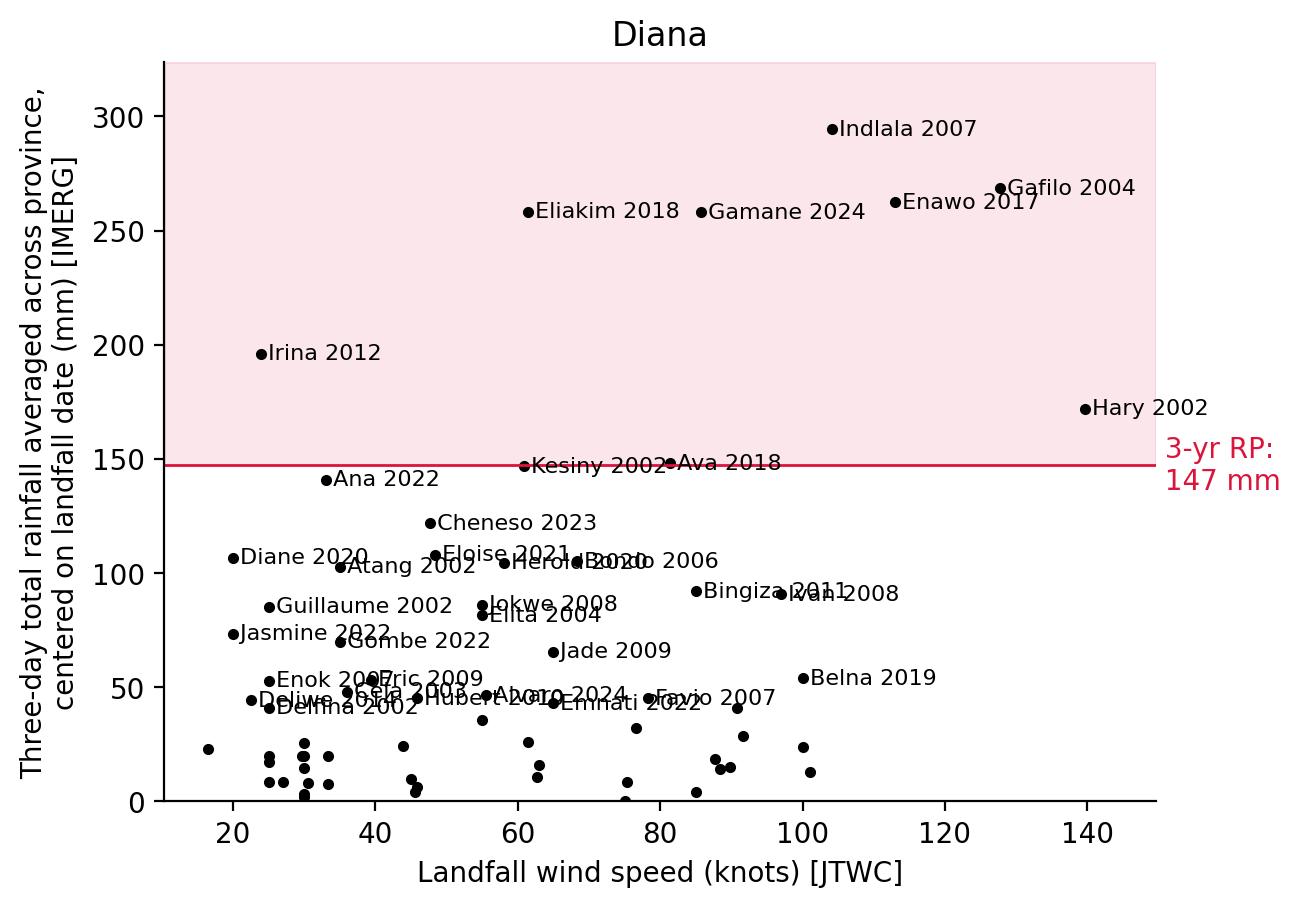

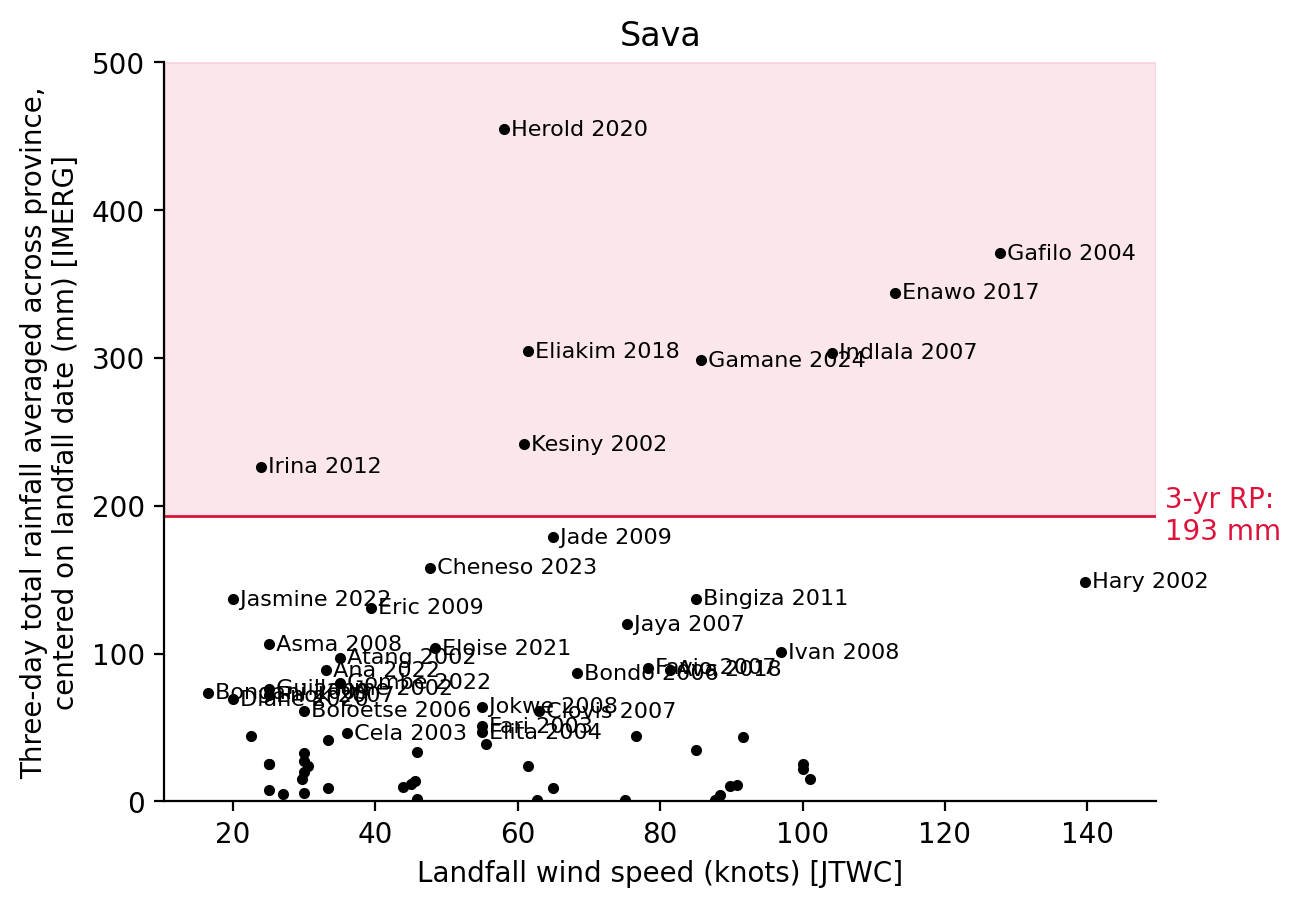

In [16]:
rp = 3
col_name = "sum_mean_rain"
color = "crimson"

for pcode, group in combined_df.groupby("pcode"):
    fig, ax = plt.subplots(dpi=200)

    # calculate RP based only on complete seasons
    dff = group[group["SEASON"] < 2024].copy()
    dff = calculate_rp(dff, col_name, total_seasons)
    dff = dff.sort_values("rp")

    # interpolate return value
    rv = np.interp(rp, dff["rp"], dff[col_name])
    top_edge = dff[col_name].max() * 1.1
    right_edge = dff["USA_WIND"].max() + 10

    group.plot(
        x="USA_WIND",
        y=col_name,
        ax=ax,
        linewidth=0,
        marker=".",
        color="k",
    )
    ax.axhline(rv, linewidth=1, color=color)
    ax.axhspan(rv, top_edge, color=color, alpha=0.1)
    ax.annotate(
        f" 3-yr RP:\n {rv:.0f} mm",
        (right_edge, rv),
        va="center",
        color=color,
    )

    # annotate high rainfall events
    for nameseason, row in group.set_index("nameseason").iterrows():
        if row[col_name] > group[col_name].median():
            ax.annotate(
                f" {nameseason}",
                (row["USA_WIND"], row[col_name]),
                fontsize=8,
                va="center",
            )

    ax.legend().remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(right=right_edge)
    ax.set_ylim(bottom=0, top=top_edge)
    ax.set_title(group.iloc[0]["ADM1_EN"])
    ax.set_xlabel("Landfall wind speed (knots) [JTWC]")
    ax.set_ylabel(
        "Three-day total rainfall averaged across province,\ncentered on landfall date (mm) [IMERG]"
    )

In [20]:
combined_df.groupby("nameseason").max().sort_values(
    by="sum_mean_rain", ascending=False
).head(10)["sum_mean_rain"]

nameseason
Manou 2003      1124.937243
Herold 2020      454.664690
Indlala 2007     450.293457
Hubert 2010      407.566136
Enawo 2017       379.564530
Gafilo 2004      371.013584
Jade 2009        355.421030
Eliakim 2018     345.728330
Gamane 2024      298.405580
Kesiny 2002      277.467999
Name: sum_mean_rain, dtype: float64

In [19]:
threshold = 300
# we want to get 7 storms so fine tuning this

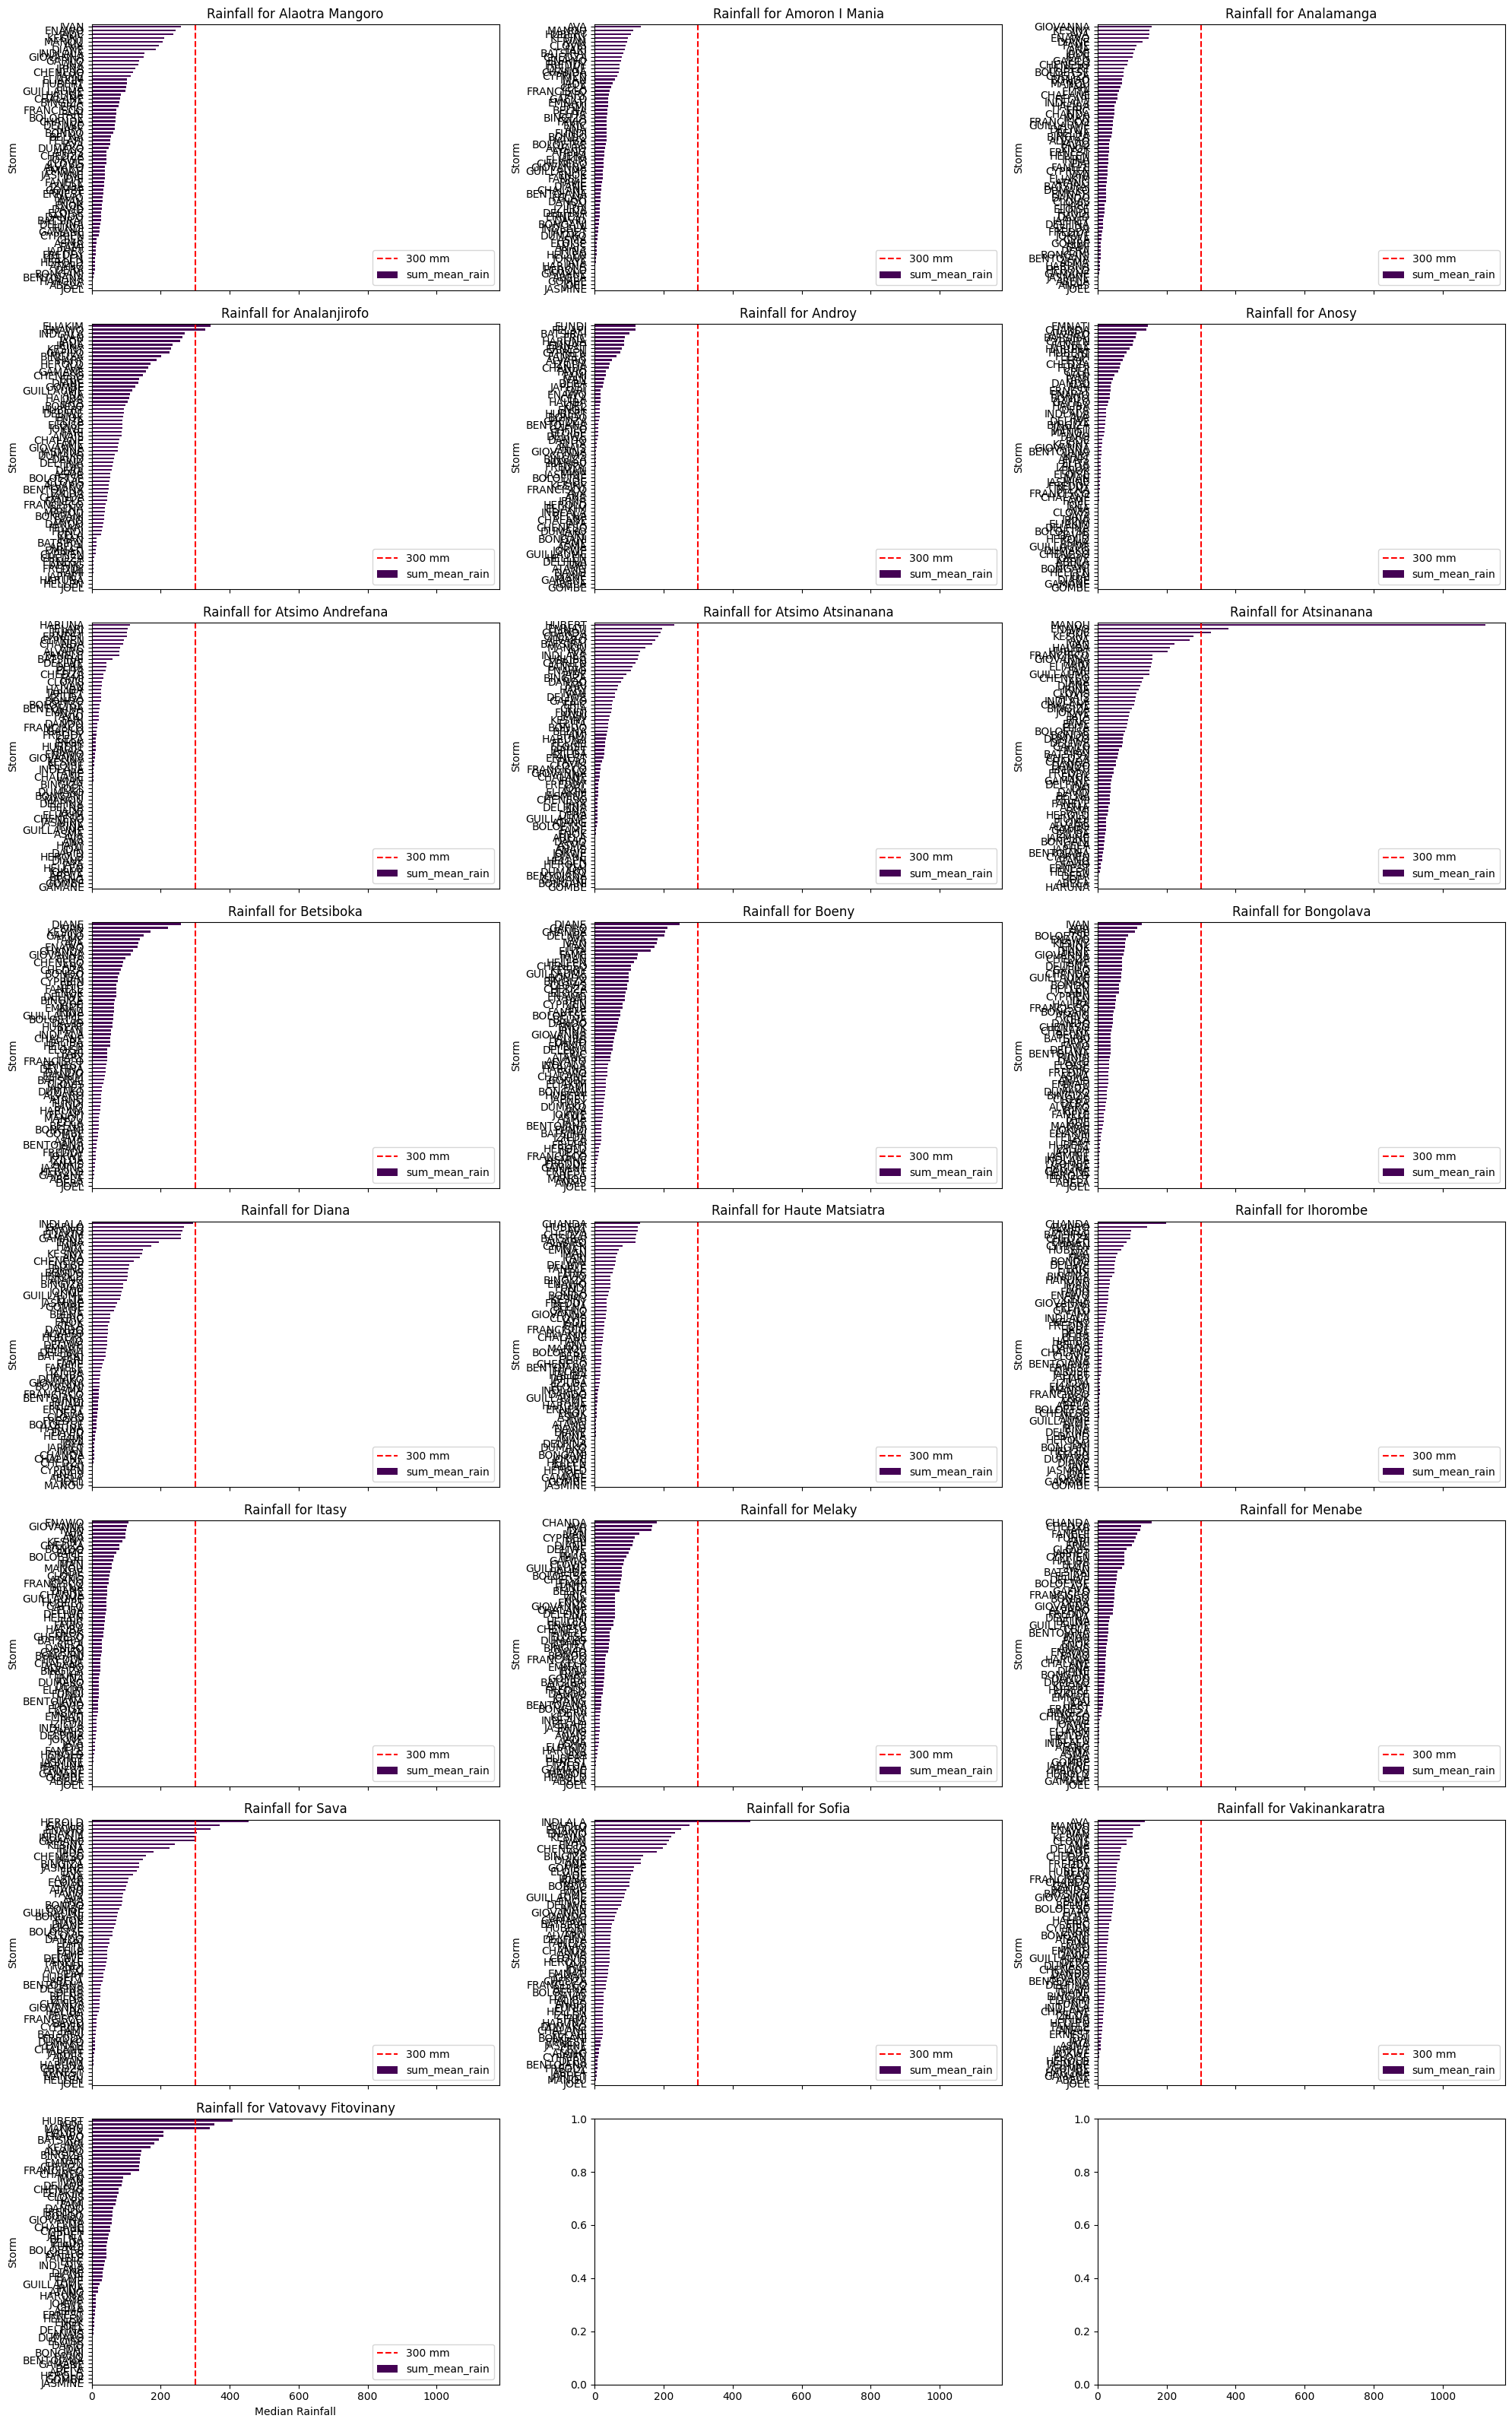

In [20]:
grouped = combined_df.groupby("ADM1_EN")

num_provinces = len(grouped)
ncols = 3
nrows = math.ceil(num_provinces / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 4 * nrows),
    sharex=True,
)

axes = axes.flatten()

for ax, (province, group) in zip(axes, grouped):
    df_pivot = group.pivot_table(
        index="NAME",
        values="sum_mean_rain",
    )
    df_pivot.fillna(0, inplace=True)

    df_pivot["total_rainfall"] = df_pivot.sum(axis=1)
    df_pivot = df_pivot.sort_values(by="total_rainfall", ascending=False)

    df_pivot.drop(columns="total_rainfall", inplace=True)

    df_pivot.plot(kind="barh", stacked=True, ax=ax, colormap="viridis")

    ax.axvline(
        x=threshold, color="red", linestyle="--", label=f"{threshold} mm"
    )

    ax.set_title(f"Rainfall for {province}")
    ax.set_xlabel("Median Rainfall")
    ax.set_ylabel("Storm")
    ax.legend(loc="lower right")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

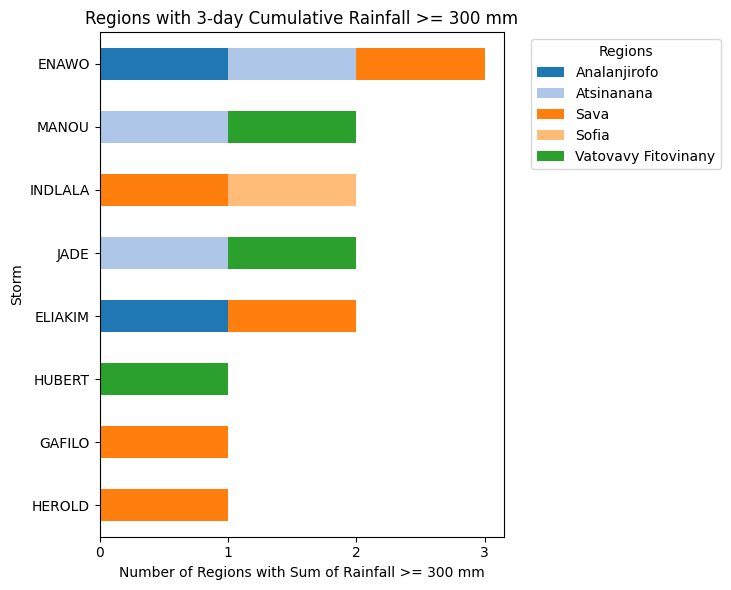

In [23]:
df_above_mm = combined_df[
    combined_df[["NAME", "ADM1_EN", "sum_mean_rain"]]["sum_mean_rain"]
    >= threshold
]

storm_pivot = (
    df_above_mm[["NAME", "ADM1_EN"]]
    .drop_duplicates()
    .groupby(["NAME", "ADM1_EN"])
    .size()
    .unstack(fill_value=0)
)

storm_pivot["total"] = storm_pivot.sum(axis=1)

storm_pivot = storm_pivot.sort_values(by="total", ascending=True).drop(
    columns=["total"]
)

unique_provinces = storm_pivot.columns
colors = cm.tab20.colors[: len(unique_provinces)]
province_color_map = dict(zip(unique_provinces, colors))

# Plot
fig, ax = plt.subplots(figsize=(7.5, 6))

storm_pivot.plot(
    kind="barh",
    stacked=True,
    ax=ax,
    color=[province_color_map[province] for province in unique_provinces],
)

ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax.set_ylabel("Storm")
ax.set_xlabel(f"Number of Regions with Sum of Rainfall >= {threshold} mm")
ax.set_title(f"Regions with 3-day Cumulative Rainfall >= {threshold} mm")

ax.legend(
    title="Regions",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    labels=unique_provinces,
)

# Adjust layout
plt.tight_layout()
plt.show()